In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import pandas_datareader.data as web
import utils

In [47]:
# from utils.data_scraper import download_ftse250_tickers 
# ftse250_list = download_ftse250_tickers(save_local=True)

# from utils.data_scraper import download_ftse250_data

# download_ftse250_data(ftse250_list, save_local=True)

In [48]:
models = utils.models
data_scraper = utils.data_scraper

In [49]:
df = data_scraper.get_ftse250_data()
df.dropna(inplace=True)
df = df[df.index.get_level_values('ticker') != 'SPY']
ftse250_list = data_scraper.get_ftse250_tickers()
ftse250_list = [ticker for ticker in ftse250_list if ticker != 'SPY']

Loaded FTSE 250 historical data from 'data/ftse250_data.csv'
Loaded 250 tickers from local file.


c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:480: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [50]:
df

adj_close       close        high         low        open  \
date       ticker                                                               
2015-01-05 3IN.L   213.248123  214.629501  215.333206  214.457794  215.333206   
           AAS.L   182.385559  182.800003  183.800003  181.699997  183.800003   
           ABDN.L  537.021057  541.130005  560.825195  539.453796  556.075989   
           AEP.L   552.170227  553.000000  554.500000  545.000000  550.000000   
           AGT.L   102.172173  102.400002  103.486000  102.000000  102.000000   
...                       ...         ...         ...         ...         ...   
2025-10-31 WKP.L   418.000000  418.000000  423.500000  415.000000  423.500000   
           WOSG.L  392.600006  392.600006  407.000000  392.600006  395.399994   
           WWH.L   359.493652  359.500000  361.500000  357.963013  361.500000   
           XPS.L   337.500000  337.500000  344.500000  325.500000  325.500000   
           ZIG.L   347.000000  347.000000  354.100006  345.000000  349.500000   

                      volume  
date       ticker             
2015-01-05 3IN.L    398390.0  
           AAS.L    293080.0  
           ABDN.L  3278734.0  
           AEP.L      5081.0  
           AGT.L    513830.0  
...                      ...  
2025-10-31 WKP.L    597059.0  
           WOSG.L  1514648.0  
           WWH.L   1576707.0  
           XPS.L    581165.0  
           ZIG.L    372299.0  

[632238 rows x 6 columns]

In [51]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['high'] - np.log(df['low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['adj_close']) - np.log(df['open']) ** 2))
df['rsi'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: pandas_ta.rsi(x, length=20))
df['bb_low'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

<Axes: xlabel='date'>

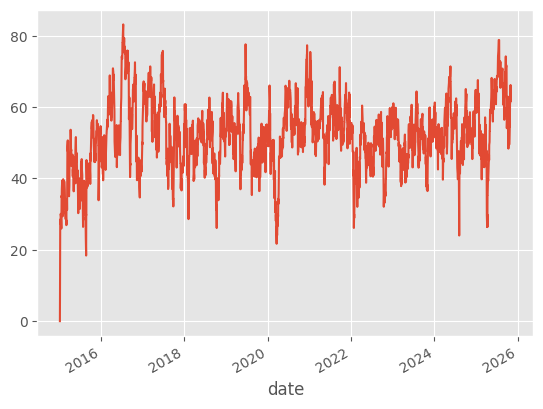

In [52]:
# All 'close' prices for ticker 'AAPL' across all dates
df.xs('AAS.L', level='ticker')['rsi'].plot()

In [53]:
df.xs('AAS.L', level='ticker').head()

,adj_close,close,high,low,open,volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high
date,,,,,,,,,,,
2015-01-05,182.385559,182.800003,183.800003,181.699997,183.800003,293080.0,11.017292,NaN,NaN,NaN,NaN
2015-01-06,181.387833,181.800003,184.000000,181.800003,183.000000,184420.0,11.002467,0.000000,NaN,NaN,NaN
2015-01-07,182.984177,183.399994,184.800003,182.121994,184.000000,77080.0,11.023511,7.766908,NaN,NaN,NaN
2015-01-08,187.274414,187.699997,188.899994,184.852997,187.399994,153765.0,11.100810,24.382058,NaN,NaN,NaN
2015-01-09,188.571457,189.000000,189.500000,186.128006,189.000000,194220.0,11.134176,28.482040,NaN,NaN,NaN


In [54]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj_close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [55]:
df = df.dropna()
df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)

In [56]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [57]:
df['macd'] = df.groupby(level='ticker', group_keys=False)['adj_close'].apply(compute_macd)

In [58]:
df['dollar_volume'] = (df['volume'] * df['adj_close'])/1e6
df['close_over_open'] = np.log(df['adj_close'] / df['open'])

In [59]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([df.unstack(level='ticker')['dollar_volume'].resample('ME').mean().stack(level='ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='ticker', future_stack=True)], axis=1).dropna()

In [60]:
data

dollar_volume   adj_close  garman_klass_volatility  \
date       ticker                                                       
2015-03-31 3IN.L      116.485051  224.015366                11.899444   
           AAS.L       53.344250  175.900269                10.805619   
           ABDN.L    2989.929505  539.415527                16.062644   
           AEP.L        4.240307  599.099792                16.500163   
           AGT.L      102.691579  108.258568                 8.919718   
...                          ...         ...                      ...   
2025-10-31 ONT.L      174.053856  137.000000                 9.845752   
           PINT.L     121.889825  104.500000                 8.901934   
           ITH.L      302.391151  217.408447                11.704243   
           DWL.L      291.643073   82.699997                 7.946528   
           RPI.L      134.140223  362.600006                14.020874   

                         rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                      
2015-03-31 3IN.L   66.351107  5.397666  5.408888  5.420109 -1.165215   
           AAS.L   41.384553  5.153452  5.186021  5.218590 -0.677297   
           ABDN.L  39.715086  6.212237  6.350553  6.488869  1.872820   
           AEP.L   51.006167  6.373262  6.390550  6.407838 -0.839283   
           AGT.L   58.324877  4.654454  4.682925  4.711396 -1.203842   
...                      ...       ...       ...       ...       ...   
2025-10-31 ONT.L   37.134122  4.896641  4.969936  5.043232 -0.928765   
           PINT.L  46.318815  4.612925  4.670563  4.728202  1.174380   
           ITH.L   64.838250  5.161128  5.283686  5.406244  0.690840   
           DWL.L   58.514100  4.320321  4.392865  4.465410 -0.755971   
           RPI.L   39.162639  5.875136  5.940400  6.005664 -0.838907   

                       macd  close_over_open  
date       ticker                             
2015-03-31 3IN.L   0.374931        -0.008328  
           AAS.L  -0.739246         0.006847  
           ABDN.L -1.367677        -0.018080  
           AEP.L  -0.067262        -0.001501  
           AGT.L   0.295037        -0.004989  
...                     ...              ...  
2025-10-31 ONT.L  -0.262577        -0.007273  
           PINT.L  0.298206        -0.032944  
           ITH.L   1.527087         0.006499  
           DWL.L   1.035564        -0.010824  
           RPI.L  -0.448705         0.007196  

[29540 rows x 10 columns]

In [61]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)

In [62]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [63]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2020-02-29 3IN.L   295.893036                13.056594  37.166016  5.694489   
           ABDN.L  275.081085                12.756622  32.734202  5.650163   
           AGT.L   138.836517                 9.889757  24.719495  4.964699   
           AO.L     61.500000                 7.114859  34.846765  4.160613   
           ASHM.L  460.205841                15.345900  27.505258  6.192683   
...                       ...                      ...        ...       ...   
2025-10-31 AJB.L   537.500000                15.985176  52.026134  6.271886   
           WOSG.L  392.600006                14.464853  57.065279  5.887584   
           TRN.L   251.600006                12.454615  38.079591  5.512096   
           HTWS.L  149.600006                10.213746  61.947030  4.960786   
           THG.L    46.480000                 6.021830  65.666147  3.586202   

                     bb_mid   bb_high       atr      macd  close_over_open  
date       ticker                                                           
2020-02-29 3IN.L   5.737373  5.780257  0.129151 -0.609471         0.009825  
           ABDN.L  5.744682  5.839200  0.920257 -0.789642         0.006862  
           AGT.L   5.037308  5.109917  0.313155 -1.939969        -0.004050  
           AO.L    4.289542  4.418471 -0.397482 -0.493096        -0.063013  
           ASHM.L  6.300169  6.407655  2.472361 -1.408190        -0.031641  
...                     ...       ...       ...       ...              ...  
2025-10-31 AJB.L   6.296943  6.322000  0.909512  0.509455        -0.006491  
           WOSG.L  5.946010  6.004436 -1.133385  0.315164        -0.007107  
           TRN.L   5.569927  5.627759 -1.312836 -0.367113        -0.017337  
           HTWS.L  4.991948  5.023111 -0.914864  0.615123        -0.010638  
           THG.L   3.787754  3.989305 -0.737061  0.497583        -0.021708  

[10350 rows x 9 columns]

In [64]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj_close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [65]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                              
2021-02-28 3IN.L    290.498749                13.041181  43.510119  5.666381   
           ABDN.L   309.614044                13.416732  50.004698  5.722923   
           AGT.L    174.032013                10.816648  45.196443  5.151537   
           ASHM.L   410.793060                14.753598  35.284480  6.028602   
           ASL.L   1350.119873                20.790069  67.160624  7.075935   
...                        ...                      ...        ...       ...   
2025-10-31 SSON.L  1546.000000                21.665858  54.995900  7.314852   
           CHRY.L   121.599998                 9.238127  51.893148  4.768887   
           AJB.L    537.500000                15.985176  52.026134  6.271886   
           WOSG.L   392.600006                14.464853  57.065279  5.887584   
           TRN.L    251.600006                12.454615  38.079591  5.512096   

                     bb_mid   bb_high       atr      macd  close_over_open  \
date       ticker                                                            
2021-02-28 3IN.L   5.688331  5.710281  0.481260 -0.723606        -0.005155   
           ABDN.L  5.765528  5.808134  0.331109  0.847100        -0.021048   
           AGT.L   5.195429  5.239322  0.712414  0.020345        -0.005547   
           ASHM.L  6.120496  6.212389  1.383365 -1.000600        -0.022165   
           ASL.L   7.142105  7.208275  1.400913  1.310679         0.015014   
...                     ...       ...       ...       ...              ...   
2025-10-31 SSON.L  7.337074  7.359296 -0.760297  0.249538        -0.002584   
           CHRY.L  4.803632  4.838377 -0.649602  0.069546         0.030052   
           AJB.L   6.296943  6.322000  0.909512  0.509455        -0.006491   
           WOSG.L  5.946010  6.004436 -1.133385  0.315164        -0.007107   
           TRN.L   5.569927  5.627759 -1.312836 -0.367113        -0.017337   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-02-28 3IN.L   -0.025126  -0.027989  -0.010102  -0.000830   0.005328   
           ABDN.L   0.028798   0.051128   0.046865   0.046071   0.020803   
           AGT.L    0.018713  -0.006255   0.019531   0.032981   0.032901   
           ASHM.L  -0.085587  -0.022043  -0.007484  -0.003617  -0.004237   
           ASL.L    0.136341   0.040927   0.047650   0.076893   0.043611   
...                      ...        ...        ...        ...        ...   
2025-10-31 SSON.L   0.007823   0.015218   0.000864   0.012143  -0.001001   
           CHRY.L   0.003300   0.022093   0.001650   0.043102   0.018836   
           AJB.L   -0.007387   0.027110  -0.000619   0.041489   0.020707   
           WOSG.L   0.074439   0.096395   0.038435   0.017399  -0.041511   
           TRN.L   -0.098854  -0.032163  -0.027792  -0.023844  -0.039025   

                   return_12m  
date       ticker              
2021-02-28 3IN.L    -0.001532  
           ABDN.L    0.009904  
           AGT.L     0.019007  
           ASHM.L   -0.009421  
           ASL.L     0.008211  
...                       ...  
2025-10-31 SSON.L    0.008181  
           CHRY.L    0.029988  
           AJB.L     0.015982  
           WOSG.L   -0.002997  
           TRN.L    -0.035408  

[8174 rows x 15 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [66]:
utils.data_scraper.download_uk_famafrench_data(save_local=True)

Loaded Fama-French factors using key 'F-F_Research_Data_5_Factors_2x3'


c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:227: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader(key, 'famafrench', start='2010')[0]
c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:227: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader(key, 'famafrench', start='2010')[0]


,mkt_rf,smb,hml,rmw,cma
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0207
2025-08-31,0.0185,0.0488,0.0442,-0.0068,0.0207


In [67]:
factor_data = data_scraper.get_uk_famafrench_data()
factor_data

Loaded Fama-French factors from 'data/uk_famafrench_factors.csv'


,mkt_rf,smb,hml,rmw,cma
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0207
2025-08-31,0.0185,0.0488,0.0442,-0.0068,0.0207


In [68]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

mkt_rf     smb    hml     rmw     cma  return_1m
date       ticker                                                  
2021-02-28 3IN.L   0.0281  0.0450  0.072  0.0033 -0.0199  -0.025126
           ABDN.L  0.0281  0.0450  0.072  0.0033 -0.0199   0.028798
           AGT.L   0.0281  0.0450  0.072  0.0033 -0.0199   0.018713
           ASHM.L  0.0281  0.0450  0.072  0.0033 -0.0199  -0.085587
           ASL.L   0.0281  0.0450  0.072  0.0033 -0.0199   0.136341
...                   ...     ...    ...     ...     ...        ...
2025-10-31 WIZZ.L  0.0195 -0.0131 -0.031 -0.0522 -0.0403  -0.093506
           WKP.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.054224
           WOSG.L  0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.074439
           WWH.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.096037
           ZIG.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.064417

[8174 rows x 6 columns]

In [69]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 12]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

mkt_rf     smb    hml     rmw     cma  return_1m
date       ticker                                                  
2021-02-28 3IN.L   0.0281  0.0450  0.072  0.0033 -0.0199  -0.025126
           ABDN.L  0.0281  0.0450  0.072  0.0033 -0.0199   0.028798
           AGT.L   0.0281  0.0450  0.072  0.0033 -0.0199   0.018713
           ASHM.L  0.0281  0.0450  0.072  0.0033 -0.0199  -0.085587
           ASL.L   0.0281  0.0450  0.072  0.0033 -0.0199   0.136341
...                   ...     ...    ...     ...     ...        ...
2025-10-31 VTY.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403  -0.003403
           WIZZ.L  0.0195 -0.0131 -0.031 -0.0522 -0.0403  -0.093506
           WKP.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.054224
           WWH.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.096037
           ZIG.L   0.0195 -0.0131 -0.031 -0.0522 -0.0403   0.064417

[8090 rows x 6 columns]

In [70]:
from utils.models import calculate_betas

betas = calculate_betas(factor_data, method='rls')


In [71]:
betas

mkt_rf       smb       hml       rmw       cma
date       ticker                                                  
2021-02-28 3IN.L        NaN       NaN       NaN       NaN       NaN
           ABDN.L       NaN       NaN       NaN       NaN       NaN
           AGT.L        NaN       NaN       NaN       NaN       NaN
           ASHM.L       NaN       NaN       NaN       NaN       NaN
           ASL.L        NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-10-31 VTY.L   0.983491 -0.279560  1.746143  0.329370 -0.608358
           WIZZ.L  0.267971 -0.551517  1.373380  0.358247 -0.407379
           WKP.L   0.779724  0.301045  0.370015  0.157951 -1.096498
           WWH.L   0.429643 -0.004171  0.196667 -0.502142 -0.614322
           ZIG.L   1.156915 -0.139390  0.388058  0.446624 -0.452952

[8090 rows x 5 columns]

In [72]:
factors = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
group_data = data.join(betas.groupby(level='ticker').shift())
group_data.loc[:, factors] = group_data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [73]:
group_data = group_data.dropna()
group_data = group_data.drop('adj_close', axis=1)

In [74]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7863 entries, (Timestamp('2021-02-28 00:00:00'), '3IN.L') to (Timestamp('2025-10-31 00:00:00'), 'SUPR.L')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  7863 non-null   float64
 1   rsi                      7863 non-null   float64
 2   bb_low                   7863 non-null   float64
 3   bb_mid                   7863 non-null   float64
 4   bb_high                  7863 non-null   float64
 5   atr                      7863 non-null   float64
 6   macd                     7863 non-null   float64
 7   close_over_open          7863 non-null   float64
 8   return_1m                7863 non-null   float64
 9   return_2m                7863 non-null   float64
 10  return_3m                7863 non-null   float64
 11  return_6m                7863 non-null   float64
 12  return_9m                7863 non-null   float64
 

In [75]:
# import importlib
# import utils.models
# importlib.reload(utils.models)

In [76]:
# Prepare supervised target and features (assumes `data` exists)
feature_data = group_data.copy()
feature_data['target_1m'] = feature_data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'close_over_open',
    'atr', 'macd', 'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
    'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
]

# features = [
#     'rsi', 'garman_klass_volatility', 'atr', 'macd',
#     'bb_low', 'bb_mid', 'bb_high',
#     'return_1m', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
# ]

model_df = feature_data.reset_index().dropna(subset=features + ['target_1m'])

from utils.models import rolling_train_predict_windowed
# Run the windowed rolling trainer
fixed_dates_pred, preds_df, last_model, scaler = rolling_train_predict_windowed(
    model_df, features,
    top_k=15, model_type='randomforest', tune_model=True,
    window_months=12, min_train_rows=150
)

# Use this mapping for downstream optimisation / backtest
# Offset the dates by 1 day so they start at the beginning of each month
fixed_dates = {}
for d, tickers in fixed_dates_pred.items():
    # Parse date, add 1 day, then set to first day of the month
    new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
    fixed_dates[new_date.strftime('%Y-%m-%d')] = tickers
print(f'Created fixed_dates for {len(fixed_dates)} months')


# Optional: show last model interpretability
if last_model is not None:
    try:
        if hasattr(last_model, 'coef_'):
            coeffs = pd.Series(last_model.coef_, index=features).sort_values(ascending=False)
            print('Ridge coefficients (last model):')
            print(coeffs)
        elif hasattr(last_model, 'feature_importances_'):
            imps = pd.Series(last_model.feature_importances_, index=features).sort_values(ascending=False)
            print('Feature importances (last model):')
            print(imps)
    except Exception as e:
        print('Model inspection error:', e)
else:
    print('No model trained (insufficient history).')

Created fixed_dates for 54 months
Feature importances (last model):
close_over_open            0.114266
return_3m                  0.113937
smb                        0.107214
hml                        0.095100
return_9m                  0.091680
return_1m                  0.089293
cma                        0.089140
mkt_rf                     0.044616
rmw                        0.040330
atr                        0.040282
return_6m                  0.033952
return_2m                  0.024449
macd                       0.023988
bb_mid                     0.021634
rsi                        0.019346
bb_low                     0.018522
bb_high                    0.017301
garman_klass_volatility    0.014950
dtype: float64


In [77]:
# Add next month predictions
future_investment_data = group_data.copy()
future_investment = future_investment_data.drop('return_1m', axis=1).groupby('ticker')

# print('feature_data info', feature_data.info())
future_model_df = future_investment_data.reset_index().dropna(subset=features)

last_date = future_model_df['date'].max()
print('last_date', last_date)
future_date = last_date + pd.DateOffset(days=1)
print(future_date)
pool = future_model_df[future_model_df['date'] == last_date].dropna(subset=features).copy()

X_pred = scaler.transform(pool[features])
y_pred = last_model.predict(X_pred)

pool = pool.assign(y_pred=y_pred)

selected = pool[pool['y_pred'] > 0].nlargest(10, 'y_pred')
fixed_dates[future_date.strftime('%Y-%m-%d')] = selected['ticker'].tolist()

last_date 2025-10-31 00:00:00
2025-11-01 00:00:00


In [78]:
fixed_dates

{'2021-05-01': ['KIE.L',
  'FGP.L',
  'INVP.L',
  'SNR.L',
  'ITV.L',
  'MGNS.L',
  'HTG.L',
  'EOT.L',
  'ZIG.L',
  'RAT.L',
  'FRAS.L',
  'ELM.L',
  'HILS.L',
  'FUTR.L',
  'GRG.L'],
 '2021-06-01': ['HTG.L',
  'SNR.L',
  'KIE.L',
  'MTO.L',
  'FGP.L',
  'SPI.L',
  'SVS.L',
  'FUTR.L',
  'CCR.L',
  'BGEO.L',
  'FRAS.L',
  'TCAP.L',
  'IGG.L',
  'GNC.L',
  'MGNS.L'],
 '2021-07-01': ['KIE.L',
  'VTY.L',
  'SNR.L',
  'HMSO.L',
  'CBG.L',
  'TCAP.L',
  'MTO.L',
  'FUTR.L',
  'PAGE.L',
  'BWY.L',
  'CCC.L',
  'ELM.L',
  'RAT.L',
  'IGG.L',
  'RSW.L'],
 '2021-08-01': ['MTO.L',
  'KIE.L',
  'VTY.L',
  'MGNS.L',
  'FUTR.L',
  'JUST.L',
  'BGEO.L',
  'HMSO.L',
  'CBG.L',
  'WKP.L',
  'BRWM.L',
  'ZIG.L',
  'PAGE.L',
  'HRI.L',
  'BREE.L'],
 '2021-09-01': ['EDIN.L',
  'MTO.L',
  'FUTR.L',
  'GNC.L',
  'MONY.L',
  'HTG.L',
  'KIE.L',
  'INVP.L',
  'GEN.L',
  'CBG.L',
  'SVS.L',
  'BGEO.L',
  'HMSO.L',
  'HILS.L',
  'SNR.L'],
 '2021-10-01': ['SNR.L',
  'KIE.L',
  'FUTR.L',
  'GEN.L',
  'CCC.L',
 

In [79]:
selected

,date,ticker,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,atr,macd,close_over_open,...,return_3m,return_6m,return_9m,return_12m,mkt_rf,smb,hml,rmw,cma,y_pred
7810,2025-10-31,OCDO.L,11.746687,34.526461,5.392198,5.468904,5.545610,-1.028996,-0.164377,0.005033,...,-0.114821,-0.040794,-0.035134,-0.037799,-0.024288,3.592092,0.847424,0.652861,-1.947622,0.098017
7831,2025-10-31,SMWH.L,17.155075,43.982369,6.428643,6.500448,6.572254,-1.319428,0.006329,-0.007369,...,-0.129556,-0.047356,-0.068070,-0.054217,2.018624,0.173848,-0.091135,1.424119,-0.365169,0.070721
7838,2025-10-31,TATE.L,14.330418,35.859005,5.898517,5.944425,5.990333,-1.401201,-1.140949,0.001384,...,-0.100954,-0.055852,-0.051991,-0.047826,-0.480055,1.568686,-0.527467,-0.021747,-0.163247,0.044087
7760,2025-10-31,DOM.L,11.313277,45.264454,5.223296,5.273039,5.322783,-1.923991,-0.029329,-0.010220,...,-0.067555,-0.052422,-0.046995,-0.035671,0.719405,0.152775,0.657485,-0.000179,-0.899310,0.029318
7823,2025-10-31,QQ.L,15.341971,43.574079,6.138456,6.196895,6.255334,1.231475,-0.974419,0.009221,...,-0.011946,0.033872,0.028351,0.003646,1.079576,0.293395,-0.979857,2.992553,1.205062,0.029124
7747,2025-10-31,CCC.L,25.371898,66.255969,7.862138,7.911147,7.960157,1.040431,1.636261,0.000698,...,0.076751,0.029350,0.023108,0.022695,0.724228,-0.415433,0.783691,0.790612,-2.148616,0.027918
7785,2025-10-31,HOC.L,13.673646,44.486354,5.725777,5.918488,6.111199,3.905449,-1.119826,-0.012034,...,0.058244,0.026642,0.072495,0.030839,-0.899170,-0.542682,2.013991,1.625729,-1.310670,0.025377
7751,2025-10-31,CHG.L,16.273917,52.597267,6.293170,6.343147,6.393125,1.892158,0.311532,0.000000,...,0.013767,0.062186,0.067200,0.040549,0.747100,-0.377559,0.517531,-0.668221,1.925937,0.023948
7801,2025-10-31,KIE.L,11.761039,48.807961,5.384394,5.421602,5.458810,-0.593477,0.332716,-0.009195,...,0.029954,0.086644,0.081319,0.054201,0.031540,-0.538566,1.439788,-0.387972,-2.528250,0.023385
7749,2025-10-31,CCR.L,9.735250,37.497893,4.894725,4.926910,4.959096,-1.390059,-0.398493,0.019040,...,-0.082638,-0.000931,-0.007028,-0.006169,0.671280,0.648710,-0.541245,1.319625,1.508597,0.021545


In [80]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                              
2021-02-28 3IN.L    290.498749                13.041181  43.510119  5.666381   
           ABDN.L   309.614044                13.416732  50.004698  5.722923   
           AGT.L    174.032013                10.816648  45.196443  5.151537   
           ASHM.L   410.793060                14.753598  35.284480  6.028602   
           ASL.L   1350.119873                20.790069  67.160624  7.075935   
...                        ...                      ...        ...       ...   
2025-10-31 SSON.L  1546.000000                21.665858  54.995900  7.314852   
           CHRY.L   121.599998                 9.238127  51.893148  4.768887   
           AJB.L    537.500000                15.985176  52.026134  6.271886   
           WOSG.L   392.600006                14.464853  57.065279  5.887584   
           TRN.L    251.600006                12.454615  38.079591  5.512096   

                     bb_mid   bb_high       atr      macd  close_over_open  \
date       ticker                                                            
2021-02-28 3IN.L   5.688331  5.710281  0.481260 -0.723606        -0.005155   
           ABDN.L  5.765528  5.808134  0.331109  0.847100        -0.021048   
           AGT.L   5.195429  5.239322  0.712414  0.020345        -0.005547   
           ASHM.L  6.120496  6.212389  1.383365 -1.000600        -0.022165   
           ASL.L   7.142105  7.208275  1.400913  1.310679         0.015014   
...                     ...       ...       ...       ...              ...   
2025-10-31 SSON.L  7.337074  7.359296 -0.760297  0.249538        -0.002584   
           CHRY.L  4.803632  4.838377 -0.649602  0.069546         0.030052   
           AJB.L   6.296943  6.322000  0.909512  0.509455        -0.006491   
           WOSG.L  5.946010  6.004436 -1.133385  0.315164        -0.007107   
           TRN.L   5.569927  5.627759 -1.312836 -0.367113        -0.017337   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-02-28 3IN.L   -0.025126  -0.027989  -0.010102  -0.000830   0.005328   
           ABDN.L   0.028798   0.051128   0.046865   0.046071   0.020803   
           AGT.L    0.018713  -0.006255   0.019531   0.032981   0.032901   
           ASHM.L  -0.085587  -0.022043  -0.007484  -0.003617  -0.004237   
           ASL.L    0.136341   0.040927   0.047650   0.076893   0.043611   
...                      ...        ...        ...        ...        ...   
2025-10-31 SSON.L   0.007823   0.015218   0.000864   0.012143  -0.001001   
           CHRY.L   0.003300   0.022093   0.001650   0.043102   0.018836   
           AJB.L   -0.007387   0.027110  -0.000619   0.041489   0.020707   
           WOSG.L   0.074439   0.096395   0.038435   0.017399  -0.041511   
           TRN.L   -0.098854  -0.032163  -0.027792  -0.023844  -0.039025   

                   return_12m  
date       ticker              
2021-02-28 3IN.L    -0.001532  
           ABDN.L    0.009904  
           AGT.L     0.019007  
           ASHM.L   -0.009421  
           ASL.L     0.008211  
...                       ...  
2025-10-31 SSON.L    0.008181  
           CHRY.L    0.029988  
           AJB.L     0.015982  
           WOSG.L   -0.002997  
           TRN.L    -0.035408  

[8174 rows x 15 columns]

In [81]:
stocks = feature_data.index.get_level_values('ticker').unique().tolist()

new_df = data_scraper.get_ftse250_data(tickers=stocks,
                                     start_date=feature_data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                                     end_date=feature_data.index.get_level_values('date').unique()[-1])
new_df = new_df.adj_close.unstack('ticker')

new_df

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:480: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded FTSE 250 historical data from 'data/ftse250_data.csv'
Filtering data between 2020-02-28 00:00:00 and 2025-10-31 00:00:00
Filtering data for specified tickers


ticker,3IN.L,ABDN.L,AO.L,ASHM.L,ASL.L,ATT.L,AVON.L,BBOX.L,BBY.L,BGEO.L,...,TW.L,UKW.L,UTG.L,VCT.L,VSVS.L,VTY.L,WIZZ.L,WKP.L,WWH.L,ZIG.L
date,,,,,,,,,,,,,,,,,,,,,
2020-02-28,295.893036,275.081085,61.500000,460.205841,1223.923462,160.000000,2726.941650,129.650162,245.869675,1687.311768,...,201.458176,139.686584,1131.173706,2091.463867,421.415771,1277.028564,3415.0,1129.054810,290.364502,246.157471
2020-03-02,299.884857,274.384399,64.599998,459.807556,1215.937012,169.199997,2612.070068,131.445267,242.474243,1675.345093,...,202.155594,142.077774,1106.213867,2059.532959,418.224701,1269.040771,3324.0,1116.088379,300.359863,234.198395
2020-03-03,299.385864,278.564362,64.500000,474.543732,1237.899902,175.399994,2672.003418,135.633972,243.073425,1681.328491,...,207.037628,142.476303,1153.138062,2123.394531,429.393311,1308.979126,3385.0,1173.937744,309.855469,236.191589
2020-03-04,299.385864,284.336700,62.000000,476.734222,1255.869263,176.000000,2691.981201,136.830750,245.470184,1632.464111,...,210.325546,143.074142,1158.130127,2117.407715,413.837006,1301.989868,3487.0,1147.007935,317.851624,239.181335
2020-03-05,296.890930,275.678223,62.099998,455.073883,1227.916626,173.000000,2711.958252,134.653458,238.080139,1602.547485,...,205.144592,142.874817,1150.142944,2109.424805,399.477417,1270.039307,3350.0,1122.072876,318.851227,231.706909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-27,360.932098,206.800003,106.199997,192.875381,1548.000000,524.000000,1922.000000,153.980774,677.457886,7775.000000,...,109.300003,111.572205,593.000000,663.000000,378.799988,685.000000,1088.0,414.000000,356.993713,347.000000
2025-10-28,359.432373,206.399994,105.800003,191.076538,1558.000000,530.000000,1934.000000,153.280869,673.958069,7800.000000,...,108.449997,109.672676,578.500000,665.000000,381.000000,668.000000,1080.0,413.000000,359.993652,349.000000
2025-10-29,358.432556,205.399994,107.000000,191.076538,1556.000000,541.000000,1898.000000,153.980774,675.458008,7825.000000,...,107.099998,109.972610,576.500000,655.000000,382.799988,660.000000,1056.0,415.000000,361.993622,347.000000


In [82]:
from utils.portfolio import optimise_weights

In [83]:
returns_dataframe = new_df.pct_change().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimisation_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date]
        optimisation_df = optimisation_df[cols]
        success = False
        try:
            
            weights = optimise_weights(prices=optimisation_df,
                                lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except Exception as e:
            weights = pd.DataFrame()
            print(f"Maximium Sharpe Ratio optimization failed for start date {start_date}: {e} continuing with equal weights for all tickers")
        
        
        if success == False:
            weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],
                                   index=optimisation_df.columns.tolist(),
                                   columns=pd.Series(0)).T
            
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
            .merge(weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                right_index=True) \
            .reset_index().set_index(['date', 'ticker']).unstack().stack(future_stack=True)
            
        temp_df.index.names = ['date' , 'ticker']
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df])
    except Exception as e:
        print(f"An error occurred for start date {start_date}: {e}")
        

C:\Users\kudam\AppData\Local\Temp\ipykernel_6716\1663197055.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_dataframe = new_df.pct_change().dropna()


Optimisation failed even after fallback bounds; returning equal weights. Error: at least one of the assets must have an expected return exceeding the risk-free rate
Optimisation failed even after fallback bounds; returning equal weights. Error: at least one of the assets must have an expected return exceeding the risk-free rate


c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


Optimisation failed even after fallback bounds; returning equal weights. Error: at least one of the assets must have an expected return exceeding the risk-free rate


c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Ple

An error occurred for start date 2025-11-01: 'return'


<Axes: xlabel='date'>

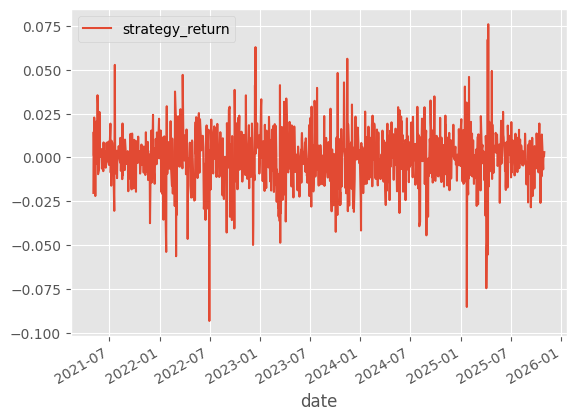

In [84]:
portfolio_df.plot()

In [85]:
# Try FTSE index first, fall back to an ETF proxy (iShares FTSE 250 UCITS ETF: MIDD.L) or FTSE 100 (^FTSE)
for candidate in ['^FTMC', 'MIDD.L', '^FTSE']:
  ftse = data_scraper.download_ftse250_data(ftse250_list=[candidate], save_local=False)
  if isinstance(ftse, pd.DataFrame) and not ftse.empty:
    print(f"Using {candidate} as FTSE proxy")
    ftse_ret = ftse.reset_index().drop('ticker', axis=1)
    ftse_ret['ftse_ret'] = ftse_ret['adj_close'].pct_change()
    ftse_ret = ftse_ret[['date', 'ftse_ret']].set_index('date').dropna()
    portfolio_df = portfolio_df.merge(ftse_ret, left_index=True, right_index=True, how='left')
    break
else:
  raise RuntimeError("Couldn't download FTSE index/ETF. Try 'MIDD.L' (iShares FTSE 250) or check data_scraper.")


1 Failed download:
['^FTMC.L']: YFTzMissingError('possibly delisted; no timezone found')


Batch 1 attempt 1 failed: Empty response from yfinance



1 Failed download:
['^FTMC.L']: YFTzMissingError('possibly delisted; no timezone found')


Batch 1 attempt 2 failed: Empty response from yfinance



1 Failed download:
['^FTMC.L']: YFTzMissingError('possibly delisted; no timezone found')


Batch 1 attempt 3 failed: Empty response from yfinance
Giving up on batch 1 after 3 attempts
No data downloaded for FTSE 250 tickers.
Using MIDD.L as FTSE proxy


c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:464: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df_wide.stack()


In [86]:
portfolio_df.to_csv('data/uk_portfolio_returns.csv')

In [87]:
portfolio_df

,strategy_return,ftse_ret
date,,
2021-05-04,-0.020279,-0.010266
2021-05-05,0.014438,0.002357
2021-05-06,0.000960,0.005174
2021-05-07,0.022729,0.013103
2021-05-10,0.004917,-0.005081
...,...,...
2025-10-27,-0.006837,0.007492
2025-10-28,0.002337,-0.001439
2025-10-29,0.000828,-0.001681


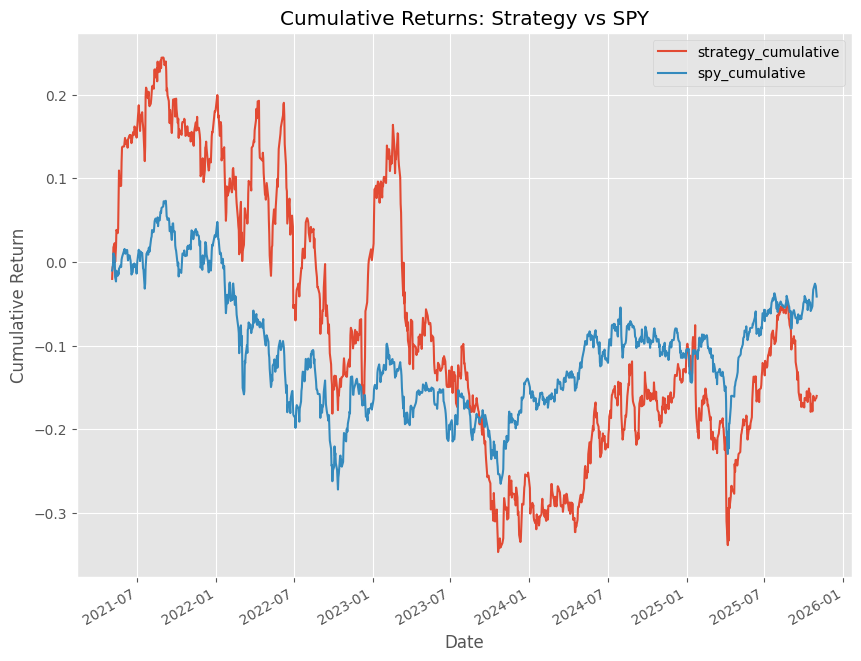

In [88]:
# Ensure portfolio_df has both simple-return columns
# 'strategy_return' should already exist; 'ftse_ret' should have been merged earlier

# Sort and align
portfolio_df = portfolio_df.sort_index()

# Keep only rows where we have both returns (or choose fillna policy)
cum_input = portfolio_df[['strategy_return', 'ftse_ret']].dropna()

# Daily cumulative simple returns
strategy_cum = (1 + cum_input['strategy_return']).cumprod() - 1
spy_cum      = (1 + cum_input['ftse_ret']).cumprod() - 1

cum_df = pd.concat([strategy_cum, spy_cum], axis=1)
cum_df.columns = ['strategy_cumulative', 'spy_cumulative']

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))
cum_df.plot(ax=ax)
ax.set_title("Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
plt.show()

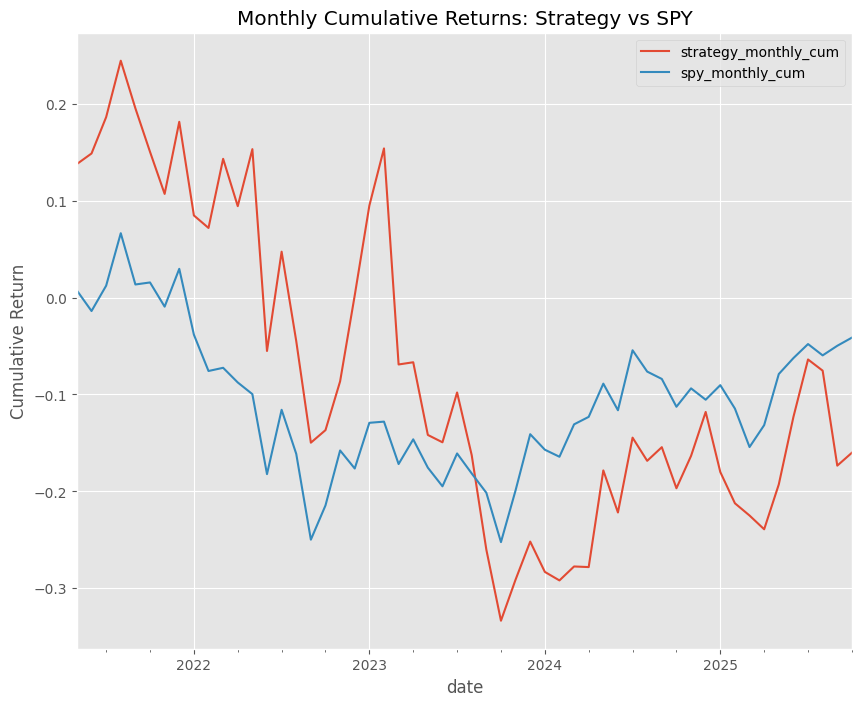

In [89]:
# Monthly simple returns from daily simple returns (product of (1+r) - 1)
monthly = (1 + cum_input['strategy_return']).resample('ME').apply(lambda x: x.prod()) - 1
monthly_spy = (1 + cum_input['ftse_ret']).resample('ME').apply(lambda x: x.prod()) - 1

monthly_cum = (1 + monthly).cumprod() - 1
monthly_spy_cum = (1 + monthly_spy).cumprod() - 1

monthly_cum_df = pd.concat([monthly_cum, monthly_spy_cum], axis=1)
monthly_cum_df.columns = ['strategy_monthly_cum', 'spy_monthly_cum']

# Plot monthly cumulative
fig, ax = plt.subplots(figsize=(10, 8))
monthly_cum_df.plot(ax=ax)
ax.set_title("Monthly Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
plt.show()

In [90]:
# 1) Basic stats of daily strategy returns
print("Strategy return head / tail / describe:")
print(portfolio_df['strategy_return'].head())
print(portfolio_df['strategy_return'].tail())
print(portfolio_df['strategy_return'].describe())

# 2) Any extreme daily returns?
print("\nTop 10 largest strategy daily returns:")
print(portfolio_df['strategy_return'].nlargest(10))
print("\nTop 10 most negative strategy daily returns:")
print(portfolio_df['strategy_return'].nsmallest(10))

# 3) Check weight sums at each rebalance (if you still have `fixed_dates` & your stored `weights` per iteration, recompute)
# If you don't store weights history, recompute weights quickly from your optimisation loop's approach:
from collections import defaultdict
weight_sums = defaultdict(float)
# Recompute sums: iterate fixed_dates and reproduce weight calculation for that period (same as your loop)
for start_date in fixed_dates.keys():
    try:
        cols = fixed_dates[start_date]
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimisation_end_date   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date][cols]
        try:
            w = optimise_weights(prices=optimisation_df, lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
            w = pd.Series(w, index=optimisation_df.columns)
        except Exception:
            w = pd.Series(1/len(optimisation_df.columns), index=optimisation_df.columns)
        weight_sums[start_date] = w.sum()
    except Exception as e:
        weight_sums[start_date] = f"error: {e}"

ws = pd.Series(weight_sums)
print("\nWeight sums across rebalances (unique values / sample):")
print(ws.value_counts().head())
print(ws.head(10))

Strategy return head / tail / describe:
date
2021-05-04   -0.020279
2021-05-05    0.014438
2021-05-06    0.000960
2021-05-07    0.022729
2021-05-10    0.004917
Name: strategy_return, dtype: float64
date
2025-10-27   -0.006837
2025-10-28    0.002337
2025-10-29    0.000828
2025-10-30    0.000575
2025-10-31    0.002993
Name: strategy_return, dtype: float64
count    1137.000000
mean       -0.000026
std         0.015653
min        -0.093296
25%        -0.008341
50%         0.000352
75%         0.008738
max         0.075950
Name: strategy_return, dtype: float64

Top 10 largest strategy daily returns:
date
2025-04-10    0.075950
2025-04-08    0.067173
2022-12-15    0.062872
2023-11-14    0.056250
2021-07-21    0.052749
2025-04-23    0.049309
2023-10-10    0.048142
2022-03-25    0.047069
2025-01-30    0.045881
2023-11-02    0.042760
Name: strategy_return, dtype: float64

Top 10 most negative strategy daily returns:
date
2022-06-30   -0.093296
2025-01-22   -0.085316
2025-04-03   -0.074626
2025-

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Ple


Weight sums across rebalances (unique values / sample):
1.00000    23
1.00000    15
1.00001     7
1.00000     4
1.00001     2
Name: count, dtype: int64
2021-05-01    1.00002
2021-06-01    0.99999
2021-07-01    1.00001
2021-08-01    1.00001
2021-09-01    1.00002
2021-10-01    1.00000
2021-11-01    1.00001
2021-12-01    1.00001
2022-01-01    1.00000
2022-02-01    1.00000
dtype: float64


c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


In [91]:
# cumulative portfolio value starting at 1.0
pv = (1 + portfolio_df['strategy_return']).cumprod()
final_return = pv.iloc[-1] - 1
print("Final cumulative return (total):", final_return)

Final cumulative return (total): -0.15549353230298335


In [92]:
N = len(portfolio_df)
cagr = pv.iloc[-1] ** (252 / N) - 1
print("Geometric annualized return (CAGR):", cagr)

Geometric annualized return (CAGR): -0.03676426383118225


In [93]:
ann_vol = portfolio_df['strategy_return'].std() * (252 ** 0.5)
ann_return_geo = (1 + portfolio_df['strategy_return']).prod() ** (252 / N) - 1
sharpe = ann_return_geo / ann_vol
print("Ann vol:", ann_vol, "Ann geom return:", ann_return_geo, "Sharpe ≈", sharpe)

Ann vol: 0.248486266894439 Ann geom return: -0.03676426383118225 Sharpe ≈ -0.14795290013673193


In [94]:
cum = (1 + portfolio_df['strategy_return']).cumprod()
rolling_max = cum.cummax()
drawdown = (cum - rolling_max) / rolling_max
print("Max drawdown:", drawdown.min())

Max drawdown: -0.47492130548233413


In [95]:
print("Duplicate rows:", portfolio_df.index.duplicated().sum())

Duplicate rows: 0


In [96]:
print("Top 10 pos/neg days:", portfolio_df['strategy_return'].nlargest(10), portfolio_df['strategy_return'].nsmallest(10))

Top 10 pos/neg days: date
2025-04-10    0.075950
2025-04-08    0.067173
2022-12-15    0.062872
2023-11-14    0.056250
2021-07-21    0.052749
2025-04-23    0.049309
2023-10-10    0.048142
2022-03-25    0.047069
2025-01-30    0.045881
2023-11-02    0.042760
Name: strategy_return, dtype: float64 date
2022-06-30   -0.093296
2025-01-22   -0.085316
2025-04-03   -0.074626
2025-04-04   -0.056468
2022-03-01   -0.056371
2025-04-09   -0.055375
2022-01-24   -0.053919
2022-12-06   -0.049943
2023-03-15   -0.048693
2022-04-12   -0.046523
Name: strategy_return, dtype: float64


In [97]:
new_df.tail()

ticker,3IN.L,ABDN.L,AO.L,ASHM.L,ASL.L,ATT.L,AVON.L,BBOX.L,BBY.L,BGEO.L,...,TW.L,UKW.L,UTG.L,VCT.L,VSVS.L,VTY.L,WIZZ.L,WKP.L,WWH.L,ZIG.L
date,,,,,,,,,,,,,,,,,,,,,
2025-10-27,360.932098,206.800003,106.199997,192.875381,1548.0,524.0,1922.0,153.980774,677.457886,7775.0,...,109.300003,111.572205,593.0,663.0,378.799988,685.000000,1088.0,414.0,356.993713,347.0
2025-10-28,359.432373,206.399994,105.800003,191.076538,1558.0,530.0,1934.0,153.280869,673.958069,7800.0,...,108.449997,109.672676,578.5,665.0,381.000000,668.000000,1080.0,413.0,359.993652,349.0
2025-10-29,358.432556,205.399994,107.000000,191.076538,1556.0,541.0,1898.0,153.980774,675.458008,7825.0,...,107.099998,109.972610,576.5,655.0,382.799988,660.000000,1056.0,415.0,361.993622,347.0
2025-10-30,356.432953,204.399994,106.000000,190.177124,1552.0,540.0,1900.0,151.581085,670.500000,7910.0,...,105.500000,106.373505,570.0,649.0,379.399994,664.200012,1058.0,416.0,361.993622,349.0
2025-10-31,357.932648,203.000000,106.400002,187.778671,1554.0,543.0,1914.0,150.081268,672.000000,8005.0,...,105.199997,105.373756,567.0,647.0,375.600006,644.200012,1047.0,418.0,359.493652,347.0


In [98]:
max_date = new_df.index.max()

In [99]:
max_date

Timestamp('2025-10-31 00:00:00')

In [100]:
portfolio_size = 2000
new_portfolio = weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True)
new_portfolio['allocation'] = new_portfolio['weight'] * portfolio_size
new_portfolio['shares'] = (new_portfolio['allocation'] / new_df.loc[max_date, new_portfolio.index]).astype(int)
new_portfolio['shares_cost'] = new_portfolio['shares'] * new_df.loc[max_date, new_portfolio.index] 
new_portfolio

,weight,allocation,shares,shares_cost
OCDO.L,0.05000,100.00,0,0.0
SMWH.L,0.05000,100.00,0,0.0
TATE.L,0.05000,100.00,0,0.0
DOM.L,0.05000,100.00,0,0.0
QQ.L,0.05000,100.00,0,0.0
CCC.L,0.05000,100.00,0,0.0
HOC.L,0.07021,140.42,0,0.0
CHG.L,0.35645,712.90,1,573.0
KIE.L,0.22334,446.68,2,433.0
CCR.L,0.05000,100.00,0,0.0
